In [42]:
## author: Virginia Ordoño Bernier
## date:January 2024

# Árbol de decisión con clasificación
El objetivo es clasificar el csv con datos sintéticos.

### Carga de datos

In [43]:
import pandas as pd

csv = './data/data2.csv'
data = pd.read_csv(csv)
df_data2 = pd.DataFrame(data)
print(df_data2.head())

   Feature_1  Feature_2  Label
0   0.496714   0.000000    0.0
1   0.647689   1.523030    0.0
2   0.000000   0.000000    0.0
3   1.579213   0.767435    0.0
4   0.000000   0.542560    0.0


In [44]:
df_data2['Label'] = df_data2['Label'].astype(int)
print(df_data2.head())

   Feature_1  Feature_2  Label
0   0.496714   0.000000      0
1   0.647689   1.523030      0
2   0.000000   0.000000      0
3   1.579213   0.767435      0
4   0.000000   0.542560      0


### Análisis exploratorio para visualizar la distribución de las clases

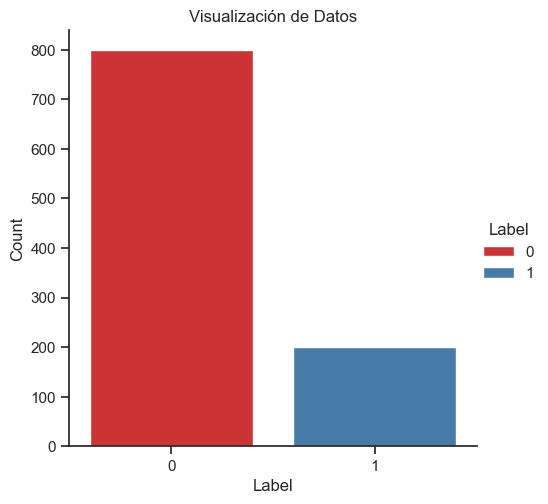

Instancias por clase
Label
0    800
1    200
dtype: int64


In [45]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='ticks') # line stlye
# kind='count' = amount of ocurrences of each class
sns.catplot(x='Label', data=df_data2, kind='count', hue='Label', palette='Set1')
plt.title("Visualización de Datos")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()
print('Instancias por clase')
print(df_data2.groupby('Label').size())

Conclusión: cantidad desequilibrada de etiquetas (80-20)

### Preparación de los datos para el entrenamiento

In [46]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_data2, test_size=0.2, random_state=42)

# Reset index to maintain an order
train.reset_index(inplace = True)
test.reset_index(inplace = True)

print("Conjunto de entrenamiento:")
print(train.head())

print("\nConjunto de prueba:")
print(test.head())

Conjunto de entrenamiento:
   index  Feature_1  Feature_2  Label
0     29   0.331263   0.975545      0
1    535   0.000000   0.477041      0
2    695   0.459972   0.000000      0
3    557   0.150419   0.364961      0
4    836   2.608242   2.077590      1

Conjunto de prueba:
   index  Feature_1  Feature_2  Label
0    521   1.078681   0.000000      0
1    737   0.000000   0.648280      0
2    740   0.722381   0.000000      0
3    660   0.056650   0.529693      0
4    411   2.298898   0.000000      0


### Validación cruzada: optimización de parámetros

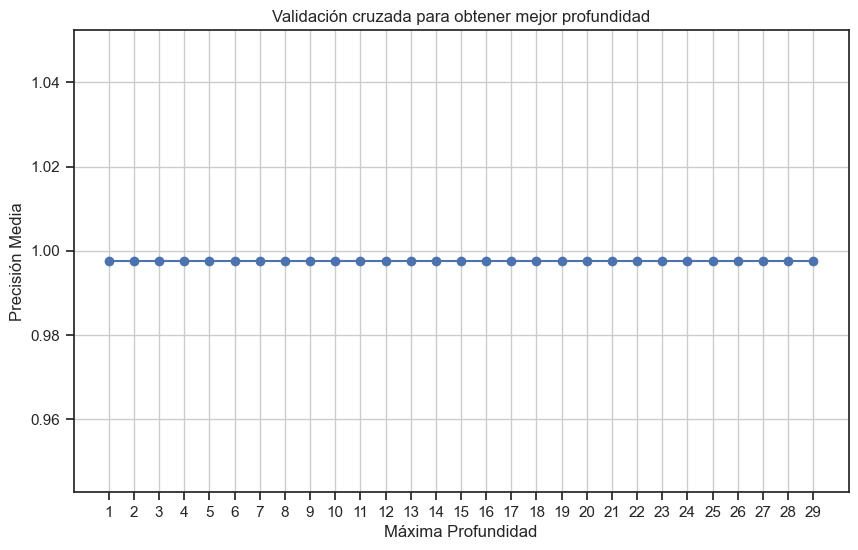

Mejor profundidad: 1
Mayor Precisión Media: 0.9975


In [47]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Supongamos que ya has dividido tus datos en train y test

cv = KFold(n_splits=4)

total_scores = []
best_depth = None
max_accuracy = 0.0

for i in range(1, 30):
    fold_accuracies = []
    dt = DecisionTreeClassifier(max_depth=i, random_state=42)

    # Divide train and test groups
    for train_fold, test_fold in cv.split(train):
        f_train = train.iloc[train_fold] # train_fold index, selects a row. F_train is a new df 
        f_test = train.iloc[test_fold] # test_fold index, selects a row. F_test is a new df

        dt.fit(
            X=f_train.drop(['Label'], axis=1),  # thorugh the column
            y=f_train['Label']
        )
        X_test = f_test.drop(['Label'], axis=1)  # thorugh the column
        y_pred = dt.predict(X_test)

        # Evaluation
        accuracy = accuracy_score(f_test['Label'], y_pred)
        fold_accuracies.append(accuracy)
    
    # Calculate and store the average accuracy for the current depth
    avg_accuracy = np.mean(fold_accuracies)
    total_scores.append(avg_accuracy)
    
    # Check if the current depth results in a bigger accuracy
    if avg_accuracy > max_accuracy:
        max_accuracy = avg_accuracy
        best_depth = i

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), total_scores, marker='o', linestyle='-', color='b')
plt.title('Validación cruzada para obtener mejor profundidad')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Precisión Media')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

# Print the results
print(f"Mejor profundidad: {best_depth}")
print(f"Mayor Precisión Media: {max_accuracy}")


### Creación del modelo con los mejores hiperparámetros 

In [48]:
from sklearn.metrics import classification_report
X_train = train[['Feature_1', 'Feature_2']]
y_train = train['Label']
X_test = test[['Feature_1', 'Feature_2']]
y_test = test['Label']

model = DecisionTreeClassifier(max_depth = 2) # all  the same
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

print("\nInforme de Clasificación Índice de Gini:")
print(classification_report(y_test, y_pred)) 


Informe de Clasificación Índice de Gini:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       156
           1       1.00      0.95      0.98        44

    accuracy                           0.99       200
   macro avg       0.99      0.98      0.99       200
weighted avg       0.99      0.99      0.99       200



### Visualizacion del árbol de decisión

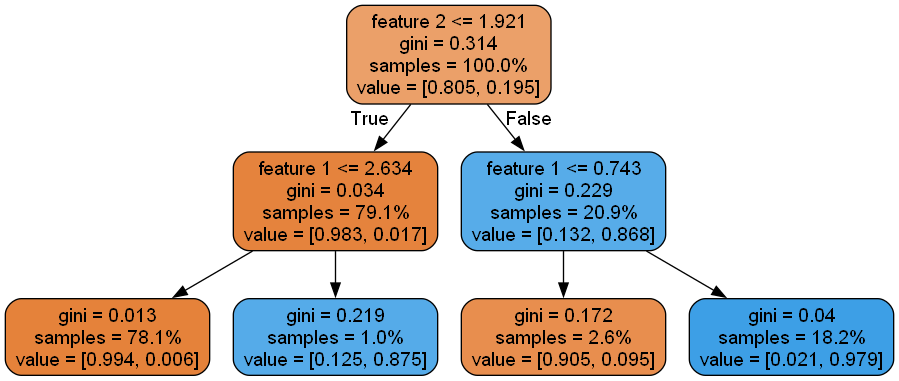

In [49]:
import pydot
from IPython.display import Image

from io import StringIO

from sklearn import tree

dot_data = StringIO()
tree.export_graphviz(model, out_file = dot_data, proportion = True, feature_names = ["feature 1", "feature 2"], rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### Importancia de las variables
La importancia de las variables se deriva del propio modelo, y se calcula observando cómo cada característica contribuye a reducir la impureza (o aumentar la pureza) de los nodos en el árbol de decisión durante el proceso de entrenamiento.

In [50]:
#X_train = train.drop('Label', axis=1)

# Gini criterio by default
classifier = tree.DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Get importance
importances = classifier.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Exclude column 'index' if exists
if 'index' in feature_importance_df['Feature'].values:
    feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'index']

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Informe de Importancia de las Variables:")
print(feature_importance_df)



Informe de Importancia de las Variables:
     Feature  Importance
1  Feature_2    0.801535
0  Feature_1    0.198465
